In [399]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

import subprocess

import numpy as np
from matplotlib import pyplot as plt

import corner

from astropy import units as u
from astropy import constants as const
from astropy.io import ascii

import fileinput
import pandas as pd

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import sys, os, glob

import time


### Toy example of SBI - SAM

 https://sbi-dev.github.io/sbi/install/

 https://astroautomata.com/blog/simulation-based-inference/

 SAM-MCMC: https://arxiv.org/pdf/0810.2548.pdf

 Absolutely read this: https://www.pnas.org/doi/full/10.1073/pnas.1912789117

Benefits over likelihod based:

- self-consistency of simulated observed data. Observed MBHF, bulge relation, LFs are often from different papers with different observational biases. Hence, the observations are not guaranteed to be self-consistent.

- speed / scalability: use deep NN to efficiently learn mapping from inputs to observations, does not suffer from increasing dimensionality adding more terms to the likelihood 

- Flexibility: Any observational quantity can be be added to the model 

Constraining black hole assembly history in semi-analytic models using simulation-based inference 

In [400]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

### Priors

Free parameters in the SAM:
- Seed power law index n
- Seed probability 
- BH feedback reheating efficiency

``theta = n, p_seed, eta_BH``.


In [401]:
prior = utils.BoxUniform(
    #                 n, pseed, eta_BH
    #low=torch.tensor([-2, 0, -4, -4, -4]),
    #high=torch.tensor([2, 1, 0, 0, 0]),

    low=torch.tensor([-4, 0, 0]),
    high=torch.tensor([4, 1, 10]),
)

### SAM interface

The code blocks below are just to interface with the SAM, you can ignore the details. The ``simulator`` function returns a zipped, 1D array of:

``x = (BH mass, stellar mass, and luminosity) x Ngalaxies``.

In [402]:
def stellarmassbin(sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into stellar mass bin %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logTSM <= highmass ) & ( lowmass < gal.logTSM ) ) ]
    return gal

#### #### #### #### #### #### this is when using halo mass bins
def halomassbin(sample, data, lowmass, highmass):

    # This function calculates what we need for specified mass bin
    print( 'Breaking down data into halo mass bins %s to %s' % (lowmass, highmass) )
    gal = param_dicts(sample, data)
    gal = gal.loc[ ( ( gal.logMvir <= highmass ) & ( lowmass < gal.logMvir ) ) ]
    return gal

In [403]:
def simulator(theta, z0=True, darksagepath='/Users/colinburke/research/DarkSage', parfilename='millennium.par',
              output_num=-1, rmdir=True, maxgals=300):
    import os
    import glob
    import shutil
    import fileinput
    import subprocess
    import numpy as np
    import torch
    import analysis_darksage as ds
    from astropy import units as u
    from astropy import constants as const
    from astropy.io import ascii

    import corner
    from matplotlib import pyplot as plt

    import pandas as pd

    from astropy.cosmology import FlatLambdaCDM, z_at_value
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    # Temp
    import random
    if output_num == -1:
        i = random.randint(0, 99999999)
    else:
        i = output_num
    print(i)

    # Generate samples from N(mu, sigma=0.5)
    # Run DARK SAGE with parameters theta
    #n, p_seed, log_kappa_R, log_kappa_Q, log_f_BH = theta
    #kappa_R = 10**log_kappa_R
    #kappa_Q = 10**log_kappa_Q
    #f_BH = 10**log_f_BH

    n, p_seed, epsilon_disk = theta
    
    print('PARS IN:', theta)

    # Filepath to the new input directory
    parfilepath = os.path.join(darksagepath, f'input_{i}', parfilename)

    # Make new input directory
    if not os.path.exists(os.path.join(darksagepath, f'input_{i}')):
        os.makedirs(os.path.join(darksagepath, f'input_{i}'))

    # Make new output directory
    outputdir = os.path.join(darksagepath, f'output_{i}/')
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)

    # Copy the input to a new parameter file
    print('Copying from....', os.path.join(darksagepath, f'input', parfilename))
    print('Copying to....', parfilepath)
    shutil.copy(os.path.join(darksagepath, f'input', parfilename), parfilepath)

    # Modify the new parameter file with theta
    with fileinput.input(parfilepath, inplace=True) as file:
        for line in file:
            line = line.replace('\n','')
            if 'OutputDir' in line:
                print(f'OutputDir {outputdir}')
            elif 'NumOutputs ' in line:
                if z0==True:
                    print(f'NumOutputs 1')
                else:
                    print(f'NumOutputs -1')
            # Parameters to vary
            elif 'SeedPowerLawIndex' in line:
                print(f'SeedPowerLawIndex {n}')
            elif 'SeedProb' in line:
                print(f'SeedProb {p_seed}')
            elif 'FeedbackReheatingEpsilon' in line:
                print(f'FeedbackReheatingEpsilon {epsilon_disk}')
            #elif 'QuasarModeEfficiency' in line:
            #    print(f'QuasarModeEfficiency {kappa_Q}')
            #elif 'BlackHoleGrowthRate' in line:
            #    print(f'BlackHoleGrowthRate {f_BH}')
            else:
                print(line)

    os.chdir(darksagepath) # Darksage can't find the extra files without this ...sigh...
    print('Running DarkSage with parfile:', parfilepath)
    subprocess.run([f"{darksagepath}/darksage", f"{parfilepath}"])  # Run dark sage w/ theta arguments

    field = ['Type', 'GalaxyIndex', 'HaloIndex', 'StellarMass', 'BlackHoleMass', 'SnapNum',
    'Mvir', 'Rvir', 'Vvir', 'Vmax', 'MergerBulgeMass', 'InstabilityBulgeMass', 'DiscSFR', 'DiscHI',
    'DiscH2', 'DiscRadii', 'DiscStars', 'ColdGas', 'HotGas', 'Heating', 'BHaccreted']

    Nannuli = 30 # number of annuli used for discs in Dark Sage
    sim = 0 # which simulation Dark Sage has been run on -- if it's new, you will need to set its defaults below.
    #   0 = Mini Millennium, 1 = Full Millennium
    #range(512) # list of file numbers you want to read; 
    #change this to range(512) if sim is full Millennium merger tree or range(7) for 50 Mpc box
    files = range(8)

    ##### READ DARK SAGE DATA #####
    #data_z0DSage = ds.darksage_snap(outputdir+fpre, files, fields=field, Nannuli=Nannuli)
    ######  ================= #####

    #massbin = "stellarbin"                                                          # Options: "stellarbin" or "halobin" or " "
    sample = "all"                                                                  # Options: 'all' , 'centrals', 'satellites'
    lowmassbin = 6.0                                                                # lower mass bin for either stellar mass or halo mass
    #highmassbin = 13.0                                                              # higher mass bin for either stellar mass or halo mass

    model_files = os.listdir(outputdir)
    # Remove the last two characters from each string in model_files
    model_files = np.unique([filename[:-2] for filename in model_files])
    print(model_files)

    gal = pd.DataFrame()

    for model in model_files:

        data_z = ds.darksage_snap(outputdir + model, files, fields=field, Nannuli=Nannuli)    
        temp_df = ds.param_dicts(sample, data_z)
        gal = pd.concat([gal, temp_df], ignore_index=True)

    df_alist = ascii.read('/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list', names=['a_value'])
    print(df_alist)
    df_alist['z'] = z_at_value(cosmo.scale_factor, df_alist['a_value'].data, zmin=-0.001)

    dz = np.diff(df_alist['z'])

    # Create a mapping dictionary for SnapNum to corresponding redshifts
    snap_to_redshift = {snap: redshift for snap, redshift in enumerate(df_alist['z'])}
    # Use map to assign redshifts based on SnapNum
    print('snap_to_redshift', snap_to_redshift)
    print(gal['SnapNum'])
    print('..........')
    gal['z'] = gal['SnapNum'].map(snap_to_redshift) #+ np.random.uniform(0, )

    gal['logBHL'] = np.log10( (0.1*gal.BHaccreted.to_numpy(dtype=np.float64)*u.Msun/u.yr*const.c**2).to(u.erg/u.s).value)
    gal['logBHL'].loc[~np.isfinite(gal['logBHL'])] = -1.0 # no BH
    gal['logBHM'].loc[~np.isfinite(gal['logBHM'])] = -1.0 # no BH
    gal['logTSM'].loc[~np.isfinite(gal['logTSM'])] = -1.0 # no BH
    gal['z'].loc[~np.isfinite(gal['z'])] = -1.0 # no BH

    # Mask poorly resolved halos or BHs that didn't grow at all
    #mask = np.isfinite(gal['logBHM']) & np.isfinite(gal['logBHL'])
    #gal = gal[mask]
    print('......................')

    mask_halo = (gal['logTSM'] > 8) & (gal['logBHM'] > 0) & (gal['logBHL'] > 0)

    dist = np.array([gal['logBHM'][mask_halo], gal['logTSM'][mask_halo], gal['logBHL'][mask_halo]]) #, gal['z']])

    print('Number of gals:', len(gal)) # 
    if maxgals > 0:
        print('Reducing to:', len(gal))
        dist = dist[:,:maxgals].T.flatten() # Only get first 10k galaxies and flatten
    else:
        dist = dist[:,:maxgals].T.flatten()
    # [MBH, Ms, L]

    # Delete input and output
    if rmdir:
        shutil.rmtree(os.path.join(darksagepath, f'input_{i}'))
        shutil.rmtree(outputdir)

    #print(thetahat)
    print('shape of output:', dist.shape)
    print('............................')
    # [MBH, Ms, L] x N 
    #     
    return torch.from_numpy(dist)

## SBI ammortized inference

This runs the SAM many times.

"RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1200 but got size 1179 for tensor number 1 in the list."
-- Increase num_sim

In [404]:
# SREE calls this "test data"

# start with SNPE?

# visualize this thing?
# plot on the conditinoalized posterior using known test data
# and can plot that likelihood

# SNRE

num_sim = 20
method = 'SNPE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    method=method,
    num_workers=6,
    num_simulations=num_sim)

40638533
41676932
PARS IN: tensor([-2.3658,  0.0506,  0.0343])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_41676932/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_41676932/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_41676932/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                 

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.624601 s.
Lastly, converting to log form and multiplying by 1e10s...
0        1.075270e+10
1        1.202667e+09
2        6.858721e+08
3        0.000000e+00
4        0.000000e+00
             ...     
36520    0.000000e+00
36521    0.000000e+00
36522    0.000000e+00
36523    0.000000e+00
36524    0.000000e+00
Name: BlackHoleMass, Length: 36525, dtype: float32
0        4.593013e+10
1        3.828901e+10
2        6.760463e+09
3        1.113207e+10
4        4.150830e+09
             ...     
36520    0.000000e+00
36521    0.000000e+00
36522    0.000000e+00
36523    0.000000e+00
36524    2.909923e+07
Name: StellarMass, Length: 36525, dtype: float32
Time: 0.008777 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

Running 20 simulations in 20 batches.:   0%|          | 0/20 [00:00<?, ?it/s]

8691942
PARS IN: tensor([-1.9600,  0.7810,  9.3500])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_8691942/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_8691942/millennium.par
69402410
PARS IN: tensor([3.2769, 0.7912, 3.3430])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_69402410/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_69402410/millennium.par
3369838
PARS IN: tensor([-2.0630,  0.4285,  0.7375])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_3369838/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_3369838/millennium.par
95750929
PARS IN: tensor([0.6167, 0.6435, 4.3072])
Copying from.... /Users/colinburke/resea

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.743966 s.
Lastly, converting to log form and multiplying by 1e10s...
0        5.674668e+08
1        4.448961e+07
2        4.938289e+07
3        9.567323e+05
4        9.566102e+05
             ...     
36537    9.559958e+05
36538    9.559954e+05
36539    9.560004e+05
36540    9.559958e+05
36541    9.559989e+05
Name: BlackHoleMass, Length: 36542, dtype: float32
0        1.310407e+09
1        1.290699e+08
2        2.206362e+08
3        0.000000e+00
4        0.000000e+00
             ...     
36537    0.000000e+00
36538    0.000000e+00
36539    0.000000e+00
36540    0.000000e+00
36541    0.000000e+00
Name: StellarMass, Length: 36542, dtype: float32
Time: 0.012863 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.782265 s.
Time: 0.833621 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.516676e+09
1        9.143914e+08
2        5.825903e+08
3        1.107627e+06
4        0.000000e+00
             ...     
36512    0.000000e+00
36513    0.000000e+00
36514    0.000000e+00
36515    0.000000e+00
36516    0.000000e+00
Name: BlackHoleMass, Length: 36517, dtype: float32
0        3.892396e+10
1        8.239978e+10
2        8.006422e+09
3        8.986868e+08
4        5.604888e+09
             ...     
36512    0.000000e+00
36513    0.000000e+00
36514    0.000000e+00
36515    0.000000e+00
36516    1.076260e+07
Name: StellarMass, Length: 36517, dtype: float32
Time: 0.010491 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.022841e+09
1        8.813843e+08
2        5.918099e+08
3        7.617230e+06
4        0.000000e+00
             ...     
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
36513    0.000000e+00
36514    0.000000e+00
Na

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_31609947/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                         BaryonFrac	      0.17
                           Hubble_h	       0.7
                           PartMass	 0.0860657
                     SFprescription	         0
                     H2prescription	         1
                        AGNrecipeOn	         2
                  SupernovaRecipeOn	         1
   

Running 20 simulations in 20 batches.:  30%|███       | 6/20 [02:42<03:40, 15.74s/it]


done file 3

	file: 4	tree: 0 of 3508
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 234.838 MB

done file 1

	file: 2	tree: 0 of 4475

done file 4

	file: 5	tree: 0 of 3833
new high mark = 234.838 MB

done file 1

	file: 2	tree: 0 of 4475
new high mark = 234.838 MB

done file 1

	file: 2	tree: 0 of 4475
new high mark = 234.838 MB

done file 1

	file: 2	tree: 0 of 4475
new high mark = 234.838 MB

done file 1

	file: 2	tree: 0 of 4475

done file 2

	file: 3	tree: 0 of 4928

done file 5

	file: 6	tree: 0 of 3119

done file 6

	file: 7	tree: 0 of 3426

done file 2

	file: 3	tree: 0 of 4928

done file 2

	file: 3	tree: 0 of 4928

done file 2

	file: 3	tr

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.777242 s.
Lastly, converting to log form and multiplying by 1e10s...
0        3.078710e+08
1        2.918499e+07
2        3.284125e+07
3        8.975083e+05
4        8.973867e+05
             ...     
36537    8.967722e+05
36538    8.967720e+05
36539    8.967770e+05
36540    8.967722e+05
36541    8.967754e+05
Name: BlackHoleMass, Length: 36542, dtype: float32
0        864485440.0
1         88934288.0
2        165558912.0
3                0.0
4                0.0
            ...     
36537            0.0
36538            0.0
36539            0.0
36540            0.0
36541            0.0
Name: StellarMass, Length: 36542, dtype: float32
Time: 0.009836 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 19.915688867

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.738747 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.206557e+08
1        3.458266e+07
2        3.601316e+07
3        8.993942e+05
4        8.992724e+05
             ...     
36537    8.986581e+05
36538    8.986577e+05
36539    8.986627e+05
36540    8.986581e+05
36541    8.986611e+05
Name: BlackHoleMass, Length: 36542, dtype: float32
0        1.207672e+09
1        1.032764e+08
2        1.876381e+08
3        0.000000e+00
4        0.000000e+00
             ...     
36537    0.000000e+00
36538    0.000000e+00
36539    0.000000e+00
36540    0.000000e+00
36541    0.000000e+00
Name: StellarMass, Length: 36542, dtype: float32
Time: 0.008865 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.712160 s.
Lastly, converting to log form and multiplying by 1e10s...
0        5.511995e+09
1        9.172764e+08
2        5.778328e+08
3        9.509086e+06
4        0.000000e+00
             ...     
36508    0.000000e+00
36509    0.000000e+00
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
Name: BlackHoleMass, Length: 36513, dtype: float32
0        3.801300e+10
1        7.924684e+10
2        8.587614e+09
3        9.779513e+08
4        5.928153e+09
             ...     
36508    0.000000e+00
36509    0.000000e+00
36510    0.000000e+00
36511    0.000000e+00
36512    1.054915e+07
Name: StellarMass, Length: 36513, dtype: float32
Time: 0.007702 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
Time: 0.721714 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Number of gals: 36516
Reducing to: 36516
shape of output: (900,)
............................
75275696
PARS IN: tensor([1.3939, 0.0638, 9.9439])
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_75275696/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_75275696/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_55462506/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                             

Running 20 simulations in 20 batches.:  60%|██████    | 12/20 [05:12<02:06, 15.78s/it]

new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864
new high mark = 36.4966 MB
new high mark = 216.169 MB

done file 0

	file: 1	tree: 0 of 2864

done file 7

['model_z0.000']
reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.708445 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.806393 s.
Lastly, converting to log form and multiplying by 1e10s...
0        6.248412e+08
1        9.890206e+07
2        8.440894e+07
3        1.855144e+05
4        1.853981e+05
             ...     
36518    1.847838e+05
36519    1.847834e+05
36520    1.847884e+05
36521    1.847837e+05
36522    1.847868e+05
Name: BlackHoleMass, Length: 36523, dtype: float32
0        2.781013e+09
1        2.860961e+08
2        6.995013e+08
3        0.000000e+00
4        0.000000e+00
             ...     
36518    0.000000e+00
36519    0.000000e+00
36520    0.000000e+00
36521    0.000000e+00
36522    0.000000e+00
Name: StellarMass, Length: 36523, dtype: float32
Time: 0.007199 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 19.915688867684146, 4: 18.243721716309153, 5: 16.7245253524478, 6: 15.343073793593568, 7: 14.08591431554505, 8: 12.94077951660795, 9: 11.896569543652449, 10: 10.943863804583119, 11: 10.073461329815169, 12: 9.277914820742547, 13: 8.549912627689915, 14: 7.883203597478417, 15: 7.272188059471154, 16: 6.711586682021701, 17: 6.196833381842807, 18: 5.723864340966829, 19: 5.288833516093361, 20: 4.888449223924803, 21: 4.519555771321351, 22: 4.179468573877026, 23: 3.865682807123173, 24: 3.575905119931277, 25: 3.308097937679926, 26: 3.0604190446950064, 27: 2.8311827405117227, 28: 2.6188614943915804, 29: 2.422044133425951, 30: 2.23948545034666, 31: 2.070027318486186, 32: 1.9126326605422006, 33: 1.7663358997547138, 34: 1.630270732014346, 35: 1.5036365280464514, 36: 1.3857181315518274, 37: 1.275846218635173, 38: 1.1734169349949723, 39: 1.0778745855402572, 40: 0.9887081114681222, 41: 0.9054623929495581, 42: 0.82769

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.673364 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.274171e+08
1        5.740030e+07
2        2.875921e+07
3        6.055156e+05
4        6.053940e+05
             ...     
36536    6.047796e+05
36537    6.047792e+05
36538    6.047842e+05
36539    6.047796e+05
36540    6.047827e+05
Name: BlackHoleMass, Length: 36541, dtype: float32
0        1.294608e+09
1        1.510103e+08
2        1.649489e+08
3        0.000000e+00
4        0.000000e+00
             ...     
36536    0.000000e+00
36537    0.000000e+00
36538    0.000000e+00
36539    0.000000e+00
36540    0.000000e+00
Name: StellarMass, Length: 36541, dtype: float32
Time: 0.007992 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.634093 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.743228e+09
1        9.683891e+08
2        6.014563e+08
3        1.372810e+06
4        0.000000e+00
             ...     
36516    0.000000e+00
36517    0.000000e+00
36518    0.000000e+00
36519    0.000000e+00
36520    0.000000e+00
Name: BlackHoleMass, Length: 36521, dtype: float32
0        3.950836e+10
1        6.950514e+10
2        7.234763e+09
3        7.796076e+08
4        4.968294e+09
             ...     
36516    0.000000e+00
36517    0.000000e+00
36518    0.000000e+00
36519    0.000000e+00
36520    1.302267e+07
Name: StellarMass, Length: 36521, dtype: float32
Time: 0.007789 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

......................
Number of gals: 36521
Reducing to: 36521
shape of output: (900,)
............................
Time: 0.639096 s.
Lastly, converting to log form and multiplying by 1e10s...
0        5.740707e+09
1        8.770307e+08
2        4.981526e+08
3        7.922068e+06
4        0.000000e+00
             ...     
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
36513    0.000000e+00
36514    0.000000e+00
Name: BlackHoleMass, Length: 36515, dtype: float32
0        3.989420e+10
1        7.621466e+10
2        1.126465e+10
3        2.071366e+09
4        8.807663e+09
             ...     
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
36513    0.000000e+00
36514    1.059942e+07
Name: StellarMass, Length: 36515, dtype: float32
Time: 0.008866 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.9804

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me


done file 2

	file: 3	tree: 0 of 4928

done file 3

	file: 4	tree: 0 of 3508

done file 4

	file: 5	tree: 0 of 3833

done file 5

	file: 6	tree: 0 of 3119

done file 6

	file: 7	tree: 0 of 3426

done file 7

['model_z0.000']
reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.421655 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

Time: 0.607060 s.
Lastly, converting to log form and multiplying by 1e10s...
0        5.809520e+09
1        9.067510e+08
2        5.828527e+08
3        9.508986e+06
4        0.000000e+00
             ...     
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
36513    0.000000e+00
36514    0.000000e+00
Name: BlackHoleMass, Length: 36515, dtype: float32
0        3.956336e+10
1        7.886610e+10
2        8.596007e+09
3        9.826126e+08
4        5.939081e+09
             ...     
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
36513    0.000000e+00
36514    1.056574e+07
Name: StellarMass, Length: 36515, dtype: float32
Time: 0.008458 s.
a_value 
--------
0.012346
0.019608
0.032258
0.047811
0.051965
0.056419
0.061188
0.066287
0.071732
 0.07754
     ...
0.781371
0.804849
0.828124
0.851138
0.873833
0.896151
0.918031
0.939414
0.960243
0.980457
     1.0
Length = 63 rows
snap_to_redshift {0: 79.9978939261469, 1: 49.99959203027681, 2: 30.000062101469677, 3: 1

 Neural network successfully converged after 78 epochs.

In [405]:
# Save the ammortized posterior
#np.save('posterior.npy', posterior)
#posterior = np.load('posterior.npy', allow_pickle=True)

### Generate mock "observed" distributions

You can ignore the code in this section. It reads some parameters for the mass, luminosity functions from real observations and generates mock observed samples `x` from them.

In [406]:
def GSMF(M_star, size=1, mean=True):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01

    if mean==False:
    
        M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
        phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
        
        phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
        
        alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
        alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    else:

        M_br = 10**logM_br*u.Msun
        phi1 = phi1*u.Mpc**-3
        
        phi2 = phi2*u.Mpc**-3

    phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    return phi

In [407]:
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    plt.plot(x[1:], np.cumsum(y*dx)/np.sum(y*dx))
    return np.interp(r, cum_values, x)

In [408]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

In [409]:
def logGSMF_blue(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)
    return phi

def logGSMF_red(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 red galaxy population (double Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi1 = 3.25*1e-3
    phi2 = 0.08*1e-3
    alpha1 = -0.45
    alpha2 = -1.45
    phi_red = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))

    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi_blue = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)

    ratio = phi_red / (phi_red + phi_blue)
    
    return phi_red

In [410]:
def pl_rvs(a, b, g, size=1):
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

(array([688., 195.,  66.,  25.,  11.,  11.,   2.,   0.,   1.,   1.]),
 array([1.00017344, 1.25432835, 1.50848325, 1.76263815, 2.01679305,
        2.27094795, 2.52510285, 2.77925776, 3.03341266, 3.28756756,
        3.54172246]),
 <BarContainer object of 10 artists>)

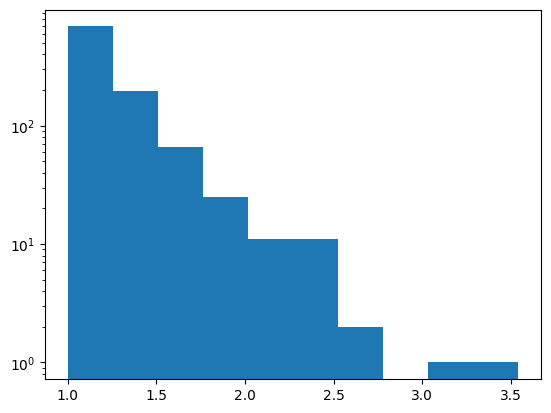

In [411]:
bh = pl_rvs(1, 100, -5, size=1000)
plt.hist(bh, log=True)

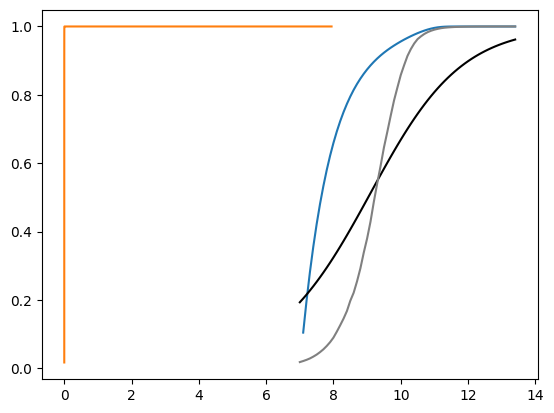

[Text(1, 1e-08, '$\\mathdefault{10^{-8}}$'), Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$')]
[Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$'), Text(1, 10.0, '$\\mathdefault{10^{1}}$')]
[Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/corner/core.py:926: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)


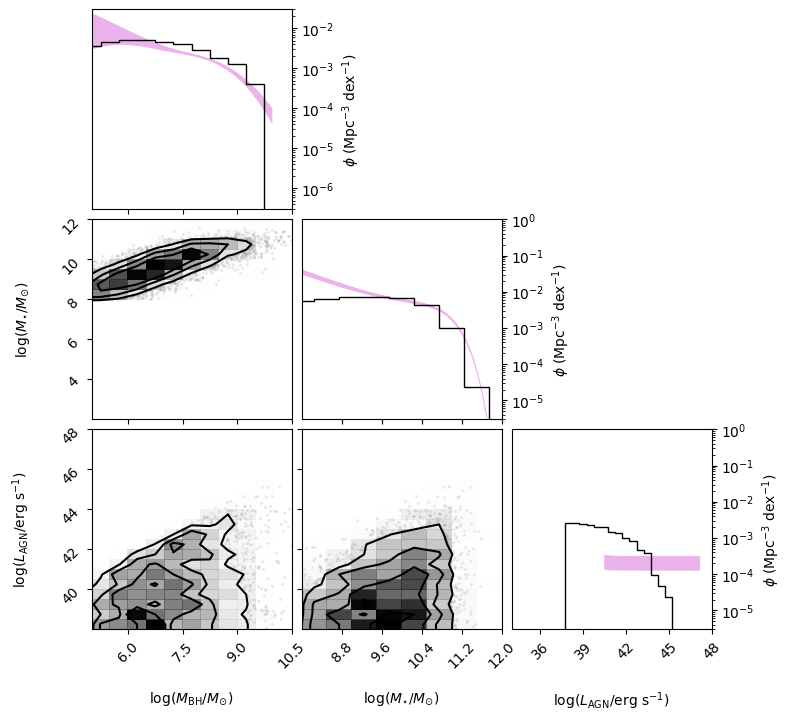

In [412]:
import scipy.stats as st
from matplotlib.ticker import LogLocator

npar = 3

# grid
dlogm = .1
logms = np.arange(7.0, 13.5, dlogm)
ms = 10**logms
dms = np.diff(ms)
dlogms = np.diff(logms)[0]

logmb = 7.45 + 1.05*(logms - 11)
mb = 10**logmb
dlogmb = np.diff(logmb)[0]

BC = 1
dlogl = 0.1
logl = logmb + 38.2 - BC
l = 10**logl
dl = np.diff(l)
dlogl = np.diff(logl)[0]

dloglam = 0.1
log_lam_min = -10
log_lam_max = 1
log_lam_eval = np.arange(log_lam_min, log_lam_max, dloglam)
lam_eval = 10**log_lam_eval
dlam_eval = np.diff(lam_eval)

Nsamp = 200
#Nsamp = len(flat_samples)

gsmf = np.zeros([len(logms), Nsamp])
gsmf_blue = np.zeros([len(logms), Nsamp])
gsmf_red = np.zeros([len(logms), Nsamp])

bhmf1_blue = np.zeros([len(logms), Nsamp])
bhmf1_red = np.zeros([len(logms), Nsamp])
bhmf1 = np.zeros([len(logms), Nsamp])

bhlf = np.zeros([len(logl), Nsamp])

# Multiwavelength flat_samples
flat_samples = np.load('../lisa_sam/flatsamples.npy')

#####################################
## Visualize the density functions ##
#####################################

for i in range(Nsamp):

    # total BH mass function is dominated by early population
    # GSH20, early-type / E, limits
    alpha_red = np.random.normal(7.89, 0.09, size=1)
    beta_red = np.random.normal(1.33, 0.12, size=1)
    sigma_red = np.random.normal(0.65, 0.05, size=1)
    logms0_red = np.log10(3*1e10)

    # grid
    logmb_red = alpha_red + beta_red*(logms - logms0_red)
    mb_red = 10**logmb_red
    dmb_red = np.diff(mb_red)

    # BH mass - stellar mass relation
    # RV15 / similar to GSH20, early-type
    alpha_blue = np.random.normal(7.45, 0.08, size=1)
    beta_blue = np.random.normal(1.05, 0.11, size=1)
    sigma_blue = np.random.normal(0.55, 0.02, size=1) # Assume 10% error on scatter
    logms0_blue = 11

    # grid
    logmb_blue = alpha_blue + beta_blue*(logms - logms0_blue)
    mb_blue = 10**logmb_blue
    dmb_blue = np.diff(mb_blue)
    dlogmb = np.diff(logmb_blue)[0]

    # LX - Ms relation
    gsmf[:,i] = logGSMF(ms)
    gsmf_blue[:,i] = logGSMF_blue(ms)
    gsmf_red[:,i] = logGSMF_red(ms)

    bhmf1_blue[:,i] = np.array([np.trapz(gsmf_blue[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_blue-logms, scale=sigma_blue)*dlogm) for logmbi in logmb_blue])
    bhmf1_red[:,i] = np.array([np.trapz(gsmf_red[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_red-logms, scale=sigma_red)*dlogm) for logmbi in logmb_red])

    # Interpolate here
    bhmf1[:,i] = np.interp(logmb, logmb_blue, bhmf1_blue[:,i]) + np.interp(logmb, logmb_red, bhmf1_red[:,i])

    C = 1
    BC = 1

    C = 1/np.trapz( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=np.diff(lam_eval))
    erdf = 1e-8 * C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
    
    bhlf[:,i] = np.array([np.trapz(np.interp(logli - log_lam_eval, logmb_red + 38.2 - BC, bhmf1[:,i]) * erdf * dloglam) for logli in logl])
    #bhlf[:,i] = np.array([np.trapz(fa * gsmf[:,i] * st.norm.pdf(logli-logms, loc=logl-logms, scale=sigma_l)*dlogm) for logli in logl])

### TODO: Need to interpolate
#bhmf1 = bhmf1_blue + bhmf1_red

#######################################
## Sample from the density functions ##
#######################################

# X-ray
V = 63**3 / 0.7
N_draw = int(V*np.trapz(np.nanpercentile(gsmf[:-1,:], 50, axis=1)*dlogm)) # int dn/dlogm dlogm = int dn = n

#### TODO: separate late/early types

# Stellar mass
dist_stellar_mass = inv_transform_sampling(np.nanpercentile(gsmf[:-1,:], 50, axis=1), np.log10(ms), N_draw)

# Black hole mass
dist_bh_mass = alpha_red + beta_red*(dist_stellar_mass - logms0_red) + np.random.normal(0, 0.81, size=len(dist_stellar_mass))

# AGN luminosity
lam_s = 10**-2.8
delta1 = 1.03
ep = 4.6
C = 1

# ERDF
erdf = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)

# np.nanpercentile(erdf[:-1,:], 50, axis=1)
dist_l_bol = 38.2 + np.log10(inv_transform_sampling(erdf[:-1], lam_eval, N_draw)) + dist_bh_mass

nsamp = 500

#######################################
## Sample from the seeding functions ##
#######################################

# Seeding
s0 = st.norm.rvs(9.37, 0.21, size=nsamp)
s5 = st.norm.rvs(0.56, 0.61, size=nsamp) # delta
s6 = st.norm.rvs(2.84, 1.2, size=nsamp) # theta

# Occupation fraction
foccs = np.zeros([nsamp, len(logms)])
for i in range(nsamp):
    foccs[i,:] = 1/(1 + np.exp(s5[i]) * np.exp(-s6[i]*(logms - s0[i])))**(1/np.exp(s5[i]))

plt.plot(logms, foccs[0,:], c='k')
plt.plot(logms, np.nanpercentile(foccs, 50, axis=0), c='gray')
plt.show()

p_seed = np.interp(dist_stellar_mass, logms, np.nanpercentile(foccs, 50, axis=0))
r_seed = st.bernoulli.rvs(p_seed)

dist_bh_mass = dist_bh_mass * r_seed + -1.0 * (1 - r_seed)

dist_l_bol = dist_l_bol * r_seed + -1.0 * (1 - r_seed)

dist_z = np.zeros_like(dist_l_bol)

# Mask 
mask_halo = (dist_stellar_mass > 8) & (dist_bh_mass > 0)

# Plot the "observed" posterior
#observation = torch.tensor([dist_bh_mass[mask_occ], dist_stellar_mass[mask_occ], dist_l_bol[mask_occ]]) #.T
observation = torch.tensor([dist_bh_mass[mask_halo], dist_stellar_mass[mask_halo], dist_l_bol[mask_halo]])

maxgals = 1000
observation_flat = observation[:,:maxgals].T.flatten()

#observation_test = observation.ravel() #[:32000] # [:8000*4] #

# Test
#observation_test = observation_test[dist_bh_mass>0]
#observation_unravel = observation_test.reshape([3, len(observation_test)//3])
#print(observation_unravel)
#d = observation_unravel.numpy().T.copy()[:,:3]

#observation_zipped = np.array(list(zip(d.ravel())))

############################
## Plot the distributions ##
############################

# Volume
V = np.full(len(observation.numpy().T), 63**3)
plot_range = np.array([[0, 10], [2, 12], [38, 48]])
bins = 20
dlogx = 10/bins

# Corner
fig = corner.corner(observation.numpy().T, labels=[r'$\log(M_{\rm BH}/M_{\odot})$', r'$\log(M_{\star}/M_{\odot})$',  r'$\log(L_{\rm AGN} / $erg s$^{-1})$'],
                    hist_kwargs={'log':True, 'align':'left'}, weights=1/V/dlogx, range=plot_range, bins=bins);
axs = np.array(fig.axes).reshape([3,3])


for j, axi in enumerate(axs):
    axs[j,0].set_xlim(5, 10.5)
    axs[j,1].set_xlim(8, 12)
    axs[j,2].set_xlim(34, 48)

axs[0,0].set_ylim(3e-7, 3e-2)
axs[1,1].set_ylim(3e-6, 1e-0)
axs[2,2].set_ylim(3e-6, 1e-0)

axs[0,0].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[0,0].yaxis.set_label_position("right")

axs[1,1].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[1,1].yaxis.set_label_position("right")

axs[2,2].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[2,2].yaxis.set_label_position("right")

for j, axi in enumerate(axs):
    axi[j].yaxis.tick_right()
    axi[j].yaxis.set_major_locator(LogLocator())

    print(axi[j].get_yticklabels() )


# density functions
axs[1,1].fill_between(np.log10(ms), np.percentile(gsmf, 16, axis=1),
                    np.percentile(gsmf, 84, axis=1),
                    color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

p_seed = np.interp(np.log10(ms), logms, np.nanpercentile(foccs[:-1,:], 50, axis=0))
axs[0,0].fill_between(np.log10(mb), p_seed*np.nanpercentile(bhmf1, 16, axis=1),
                 np.nanpercentile(bhmf1, 84, axis=1),
                 color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

axs[2,2].fill_between(np.log10(l), np.percentile(bhlf, 16, axis=1),
                 np.percentile(bhlf, 84, axis=1),
                 color="m", alpha=0.3, zorder=-1, label='mock observations', lw=0)

In [413]:
observation.numpy().T.flatten()

array([ 7.88574638, 10.2185291 , 36.6375396 , ...,  7.15254774,
        9.23610025, 41.54416921])

Above are the mock observed distributions I want to conditionalize the SAM on.

### Get conditionalized posterior distributions

Conditionalized on our mock "observed" distributions.

TODO: Currently, the we clip the data to 1000 galaxies, because the SAM can return different numbers of galaxies at z=0 depending on ``theta``.

In [416]:
observation.numpy().T.flatten()[:3000]

array([ 7.88574638, 10.2185291 , 36.6375396 , ...,  5.66422378,
        8.97008649, 37.11884318])

In [418]:
samples = posterior.sample((5000,), x=observation.numpy().T.flatten()[:3*300]) # Conditionalize the likelihood

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Drawing 5000 posterior samples: 5718it [00:00, 6424.16it/s]                          


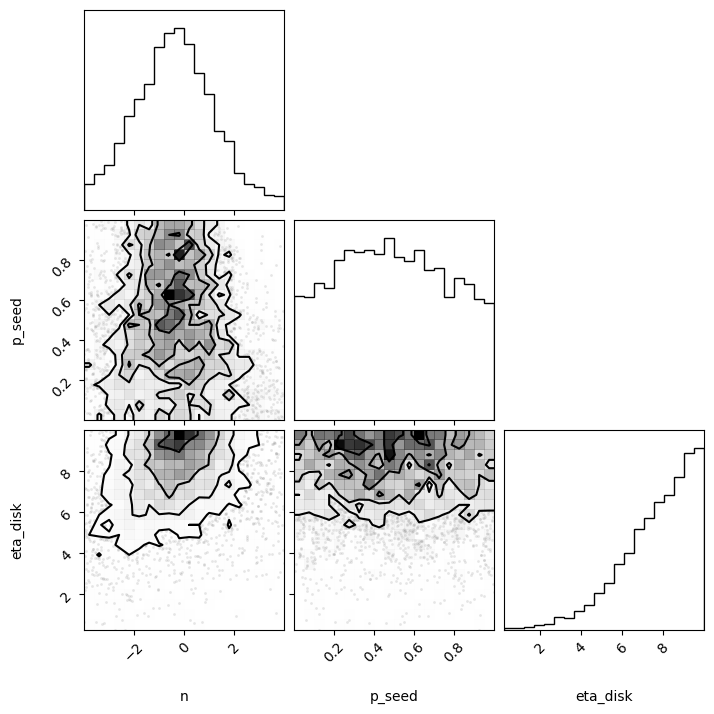

In [419]:
log_probability = posterior.log_prob(samples, x=observation.numpy().T.flatten()[:3*300])
fig = corner.corner(samples.numpy(), labels=['n', 'p_seed', 'eta_disk']);

As you can see, the posteriors are not that well constrained :(

(array([   2.,    4.,   11.,   18.,   33.,  128.,  362.,  998., 1805.,
        1639.]),
 array([-16.0863266 , -14.63377666, -13.18122578, -11.72867584,
        -10.27612591,  -8.82357597,  -7.37102556,  -5.91847515,
         -4.46592522,  -3.01337504,  -1.56082475]),
 <BarContainer object of 10 artists>)

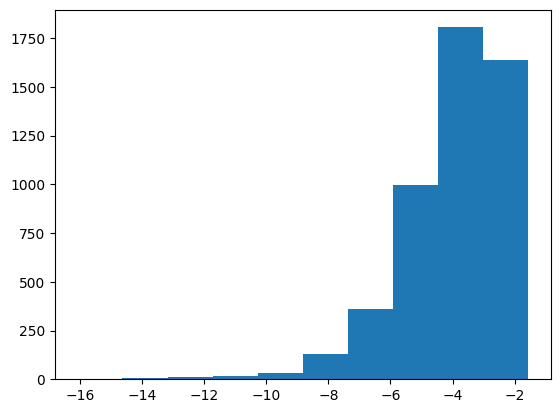

In [422]:
plt.hist(log_probability)

### Recovery Test 

Show the posterior conditionalized on a SAM with a known input ground truth ``theta``

96140964
PARS IN: [2.0, 0.2, 8.0]
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_96140964/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_96140964/millennium.par
                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_96140964/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                         BaryonFrac	      0.17

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

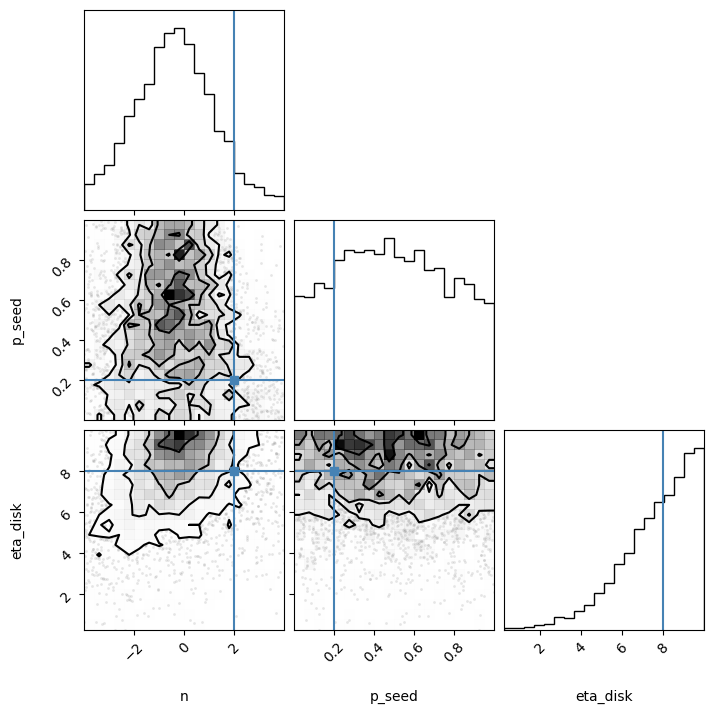

In [420]:
# TODO: loop many parameters

theta_true = [2.0, .2, 8.0] 
observation_true = simulator(theta_true)

log_probability = posterior.log_prob(samples, x=observation_true)
fig = corner.corner(samples.numpy(), labels=['n', 'p_seed', 'eta_disk'], truths=theta_true);

Again, the posteriors don't look great :(

In [421]:
observation_true.numpy().reshape([len(observation_true)//3, 3])

array([[ 9.65898705, 10.60646439, 40.52209896],
       [ 9.54372025, 10.47223663, 40.24933986],
       [ 3.11221385,  9.71730042, 36.716755  ],
       [ 9.1161499 , 10.96525574, 40.11667066],
       [ 9.63596249, 10.69866753, 40.40067253],
       [ 5.72430563,  9.70617962, 37.84614277],
       [ 9.3048687 , 10.71752357, 40.13659702],
       [ 4.36478949, 10.10368729, 38.38632999],
       [ 9.24374866, 10.51860523, 41.41692161],
       [ 8.26212406,  9.6640358 , 41.84314096],
       [ 9.13635159, 10.17543411, 38.9567775 ],
       [ 9.43484783,  9.67752552, 39.22726571],
       [ 8.95102406, 10.28364086, 39.35991279],
       [ 9.38030243, 10.63607979, 39.18300271],
       [ 4.24460936,  9.65938473, 37.58922519],
       [ 4.81637287,  9.27219772, 36.15290389],
       [ 7.73989773,  9.43159199, 37.47423298],
       [ 7.31504202,  8.88575077, 36.86523645],
       [ 4.79906893, 11.10267544, 39.6478156 ],
       [ 3.4082706 ,  8.96533394, 36.7432582 ],
       [ 7.75413227,  9.17387486, 36.834

# IGNORE BELOW #

### Get the distributions for the "best-fit" (calibrated) DarkSage simulation

Then see if our posterior matches the distribution for heavy seeding

In [ ]:
##TODO:
# - get the outputs at all redshifts
# - 

In [ ]:
light_num = 41798264
heavy_num = -1
thetabest = np.median(samples.numpy(), axis=0)
thetabest = np.array([-2, 0.6, 10.]) # Tes
print(thetabest)
simdist = simulator(thetabest, maxgals=-1, output_num=-1, rmdir=False) # model_z15.343

[-2.   0.6 10. ]
89795819
PARS IN: [-2.   0.6 10. ]
Copying from.... /Users/colinburke/research/DarkSage/input/millennium.par
Copying to.... /Users/colinburke/research/DarkSage/input_89795819/millennium.par
Running DarkSage with parfile: /Users/colinburke/research/DarkSage/input_89795819/millennium.par


                   FileNameGalaxies	     model
                          OutputDir	/Users/colinburke/research/DarkSage/output_89795819/
                          FirstFile	         0
                           LastFile	         7
                         NumOutputs	         1
                           TreeName	 trees_063
                      SimulationDir	/Users/colinburke/research/DarkSage/mini_millennium/treedata
                   FileWithSnapList	/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list
                     LastSnapShotNr	        63
                              Omega	       0.3
                        OmegaLambda	       0.7
                         BaryonFrac	      0.17
                           Hubble_h	       0.7
                           PartMass	 0.0860657
                     SFprescription	         0
                     H2prescription	         1
                        AGNrecipeOn	         2
                  SupernovaRecipeOn	         1
   

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

In [ ]:
import analysis_darksage as ds

outputdir = '/Users/colinburke/research/DarkSage/output_18719445/'

field = ['Type', 'GalaxyIndex', 'HaloIndex', 'StellarMass', 'BlackHoleMass', 'SnapNum',
'Mvir', 'Rvir', 'Vvir', 'Vmax', 'MergerBulgeMass', 'InstabilityBulgeMass', 'DiscSFR', 'DiscHI',
'DiscH2', 'DiscRadii', 'DiscStars', 'ColdGas', 'HotGas', 'Heating']


Nannuli = 30 # number of annuli used for discs in Dark Sage
sim = 0 # which simulation Dark Sage has been run on -- if it's new, you will need to set its defaults below.
#   0 = Mini Millennium, 1 = Full Millennium
#range(512) # list of file numbers you want to read; 
#change this to range(512) if sim is full Millennium merger tree or range(7) for 50 Mpc box
files = range(8)

##### READ DARK SAGE DATA #####
#data_z0DSage = ds.darksage_snap(outputdir+fpre, files, fields=field, Nannuli=Nannuli)
######  ================= #####

#massbin = "stellarbin"                                                          # Options: "stellarbin" or "halobin" or " "
sample = "all"                                                                  # Options: 'all' , 'centrals', 'satellites'
lowmassbin = 6.0                                                                # lower mass bin for either stellar mass or halo mass
#highmassbin = 13.0                                                              # higher mass bin for either stellar mass or halo mass

model_files = os.listdir(outputdir)

# Remove the last two characters from each string in model_files
model_files = np.unique([filename[:-2] for filename in model_files])
print(model_files)

gal = pd.DataFrame()

for model in model_files:

    data_z = ds.darksage_snap(outputdir + model, files, fields=field, Nannuli=Nannuli)    
    temp_df = ds.param_dicts(sample, data_z)
    gal = pd.concat([gal, temp_df], ignore_index=True)

df_alist = ascii.read('/Users/colinburke/research/DarkSage/mini_millennium/millennium.a_list', names=['a_value'])
print(df_alist)
df_alist['z'] = z_at_value(cosmo.scale_factor, df_alist['a_value'].data, zmin=-0.001)

dz = np.diff(df_alist['z'])

# Create a mapping dictionary for SnapNum to corresponding redshifts
snap_to_redshift = {snap: redshift for snap, redshift in enumerate(df_alist['z'])}
# Use map to assign redshifts based on SnapNum
print('snap_to_redshift', snap_to_redshift)
print(gal['SnapNum'])
print('..........')
gal['z'] = gal['SnapNum'].map(snap_to_redshift) #+ np.random.uniform(0, )


['model_z0.000']
reading file 0
reading file 1
reading file 2
reading file 3
reading file 4
reading file 5
reading file 6
reading file 7
Loading data...
Time taking turning dataset to pandas dataframe: 0.535833 s.
You have chosen a sample of allgalaxies.
Summing up annuli properties...
Time: 0.813544 s.
Lastly, converting to log form and multiplying by 1e10s...
0        4.514666e+09
1        8.733151e+08
2        3.043278e+08
3        8.647730e+06
4        0.000000e+00
             ...     
36508    0.000000e+00
36509    0.000000e+00
36510    0.000000e+00
36511    0.000000e+00
36512    0.000000e+00
Name: BlackHoleMass, Length: 36513, dtype: float32
0        3.889513e+10
1        7.687364e+10
2        1.099787e+10
3        2.155997e+09
4        8.861466e+09
             ...     
36508    0.000000e+00
36509    0.000000e+00
36510    0.000000e+00
36511    0.000000e+00
36512    1.056934e+07
Name: StellarMass, Length: 36513, dtype: float32
Time: 0.008560 s.
a_value 
--------
0.012346
0.01960

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, me

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 8.  ,  8.45,  8.9 ,  9.35,  9.8 , 10.25, 10.7 , 11.15, 11.6 ,
        12.05, 12.5 ]),
 <BarContainer object of 10 artists>)

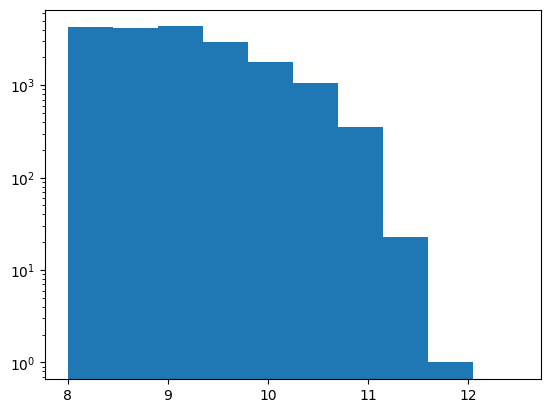

In [ ]:
plt.hist(np.log10(gal[gal.SnapNum==63].StellarMass), range=[8, 12.5], log=True)
plt.hist(np.log10(gal[gal.SnapNum==11].StellarMass), range=[8, 12.5], log=True)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-2.  , -0.55,  0.9 ,  2.35,  3.8 ,  5.25,  6.7 ,  8.15,  9.6 ,
        11.05, 12.5 ]),
 <BarContainer object of 10 artists>)

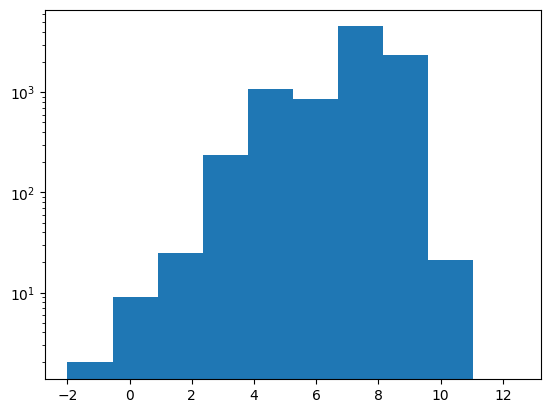

In [ ]:
plt.hist(np.log10(gal[gal.SnapNum==63].BlackHoleMass), range=[-2, 12.5], log=True)
plt.hist(np.log10(gal[gal.SnapNum==16].BlackHoleMass), range=[-2, 12.5], log=True)

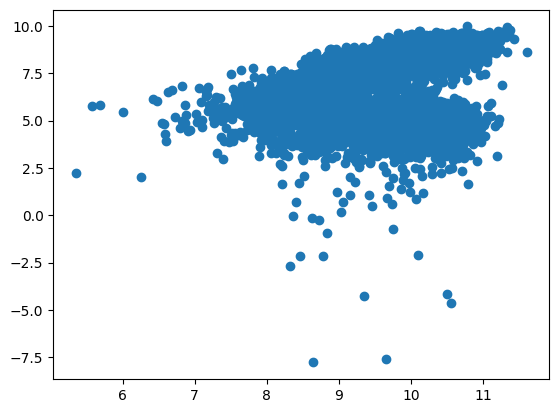

In [ ]:
plt.scatter(np.log10(gal[gal.SnapNum==63].StellarMass), np.log10(gal[gal.SnapNum==63].BlackHoleMass))
plt.scatter(np.log10(gal[gal.SnapNum==11].StellarMass), np.log10(gal[gal.SnapNum==11].BlackHoleMass))

/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/corner/core.py:926: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  return ax.set_ylim(new_ylim)


[Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$'), Text(1, 10.0, '$\\mathdefault{10^{1}}$')]
[Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$'), Text(1, 0.01, '$\\mathdefault{10^{-2}}$'), Text(1, 0.1, '$\\mathdefault{10^{-1}}$'), Text(1, 1.0, '$\\mathdefault{10^{0}}$'), Text(1, 10.0, '$\\mathdefault{10^{1}}$')]
[Text(1, 1e-07, '$\\mathdefault{10^{-7}}$'), Text(1, 1e-06, '$\\mathdefault{10^{-6}}$'), Text(1, 1e-05, '$\\mathdefault{10^{-5}}$'), Text(1, 0.0001, '$\\mathdefault{10^{-4}}$'), Text(1, 0.001, '$\\mathdefault{10^{-3}}$')

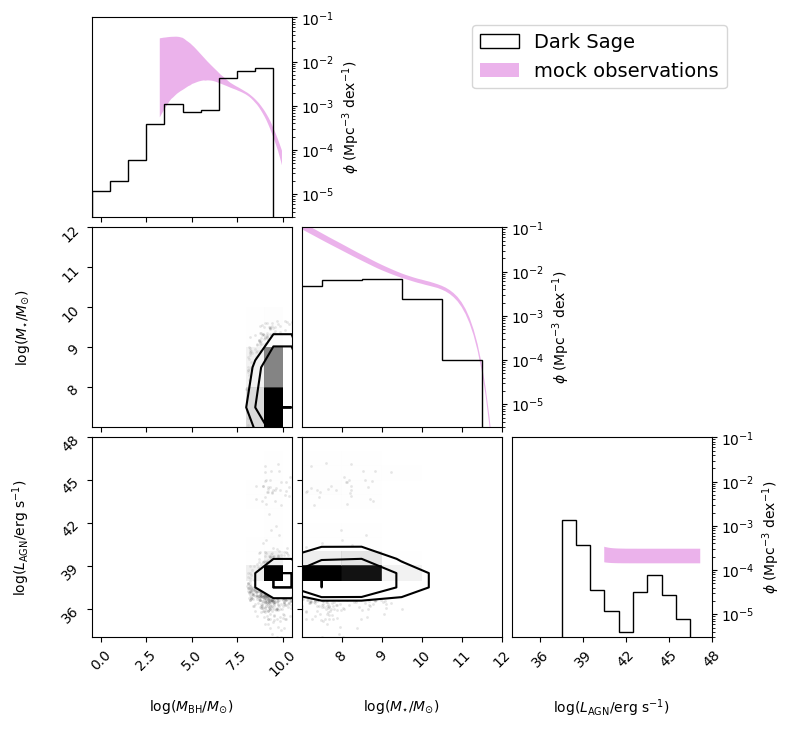

In [ ]:
npar = 3

simdist_unravel = simdist.reshape([npar, len(simdist)//npar])
V = np.full(len(simdist)//npar, 63**3) / 0.7

from matplotlib.ticker import LogLocator

d = simdist_unravel.numpy().T.copy()[:,:3]

# Volume
V = np.full(len(d), 63**3)
plot_range = np.array([[0, 10], [2, 12], [38, 48]])
bins = 10
dlogx = 10/bins

# Corner
fig = corner.corner(d, labels=[r'$\log(M_{\rm BH}/M_{\odot})$', r'$\log(M_{\star}/M_{\odot})$',  r'$\log(L_{\rm AGN} / $erg s$^{-1})$'],
                    hist_kwargs={'log':True, 'align':'left'}, weights=1/V/dlogx, range=plot_range, bins=bins);
axs = np.array(fig.axes).reshape([3,3])


#d = simdist_unravel.numpy().T.copy()[:,:3]
#print(d.shape)
#fig = corner.corner(d, labels=[r'$\log(M_{\rm BH}/M_{\odot})$', r'$\log(M_{\star}/M_{\odot})$',  r'$\log(L_{\rm AGN} / $erg s$^{-1})$'],
#                    hist_kwargs={'log':True}, weights=1/V, bins=30, plot_contours=False, no_fill_contours=True);
### TODO: Add 1/dex to weights
#axs = np.array(fig.axes).reshape([3, 3])

#m_eval = np.linspace(2, 14)
#logl = np.log10(1.26*1e38) + m_eval
#
# axs[2,0].plot(m_eval, logl, marker='o')

for j, axi in enumerate(axs):
    axs[j,0].set_xlim(-.5, 10.5)
    axs[j,1].set_xlim(7, 12)
    axs[j,2].set_xlim(34, 48)
    #axs[3,j].set_ylim(0, np.log10(15))
    #

axs[1,0].set_ylim(7, 12)
axs[2,0].set_ylim(34, 48)
axs[2,1].set_ylim(34, 48)

axs[0,0].set_ylim(3e-6, 1e-1)
axs[1,1].set_ylim(3e-6, 1e-1)
axs[2,2].set_ylim(3e-6, 1e-1)
#axs[3,3].set_ylim(3e-6, 1e-0)

#axs[3,:].set_ylim(0, np.log10(15))
#axs[3,3].set_xlim(0, np.log10(15))

#axs[3,0].set_ylim(-1, 15)
#axs[3,3].set_xlim(-1, 15)

axs[0,0].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[0,0].yaxis.set_label_position("right")

axs[1,1].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[1,1].yaxis.set_label_position("right")

axs[2,2].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
axs[2,2].yaxis.set_label_position("right")

#axs[3,3].set_ylabel(r'$\phi$ (Mpc$^{-3}$ dex$^{-1}$)')
#axs[3,3].yaxis.set_label_position("right")

for j, axi in enumerate(axs):
    axi[j].yaxis.tick_right()
    axi[j].yaxis.set_major_locator(LogLocator())

    print(axi[j].get_yticklabels() )

# relations
# logms
#axs[1,0].fill_between(logmb_red, logms-0.5, logms+0.5,
#                    color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

# density functions
axs[1,1].fill_between(np.log10(ms), np.percentile(gsmf, 16, axis=1),
                    np.percentile(gsmf, 84, axis=1),
                    color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

p_seed = np.interp(np.log10(ms), logms, np.nanpercentile(foccs[:-1,:], 50, axis=0))
axs[0,0].fill_between(np.log10(mb), p_seed*np.nanpercentile(bhmf1, 16, axis=1),
                 np.nanpercentile(bhmf1, 84, axis=1),
                 color="m", alpha=0.3, zorder=-1, lw=0, ls='dotted')

axs[2,2].fill_between(np.log10(l), np.percentile(bhlf, 16, axis=1),
                 np.percentile(bhlf, 84, axis=1),
                 color="m", alpha=0.3, zorder=-1, label='mock observations', lw=0)

axs[0,0].hist([-10, -10], color="k", zorder=-1, label='Dark Sage', lw=1, histtype='step')

##############################################################################

fig.legend(fontsize=14, bbox_to_anchor=(0.48, 0., 0.5, 0.95))

In [ ]:
# Split up results into 1st non-zero (initial seed mass)

In [ ]:
### Divide BHMF into colors
# instabilities (merger-triggered, secular)
# cold gas 
# radio mode (bondi) / hot gas)
# BH-BH mergers

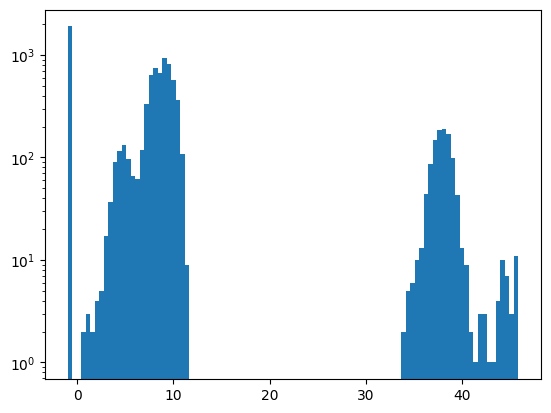

In [ ]:
plt.hist(simdist_unravel[0,:], log=True, bins=100);

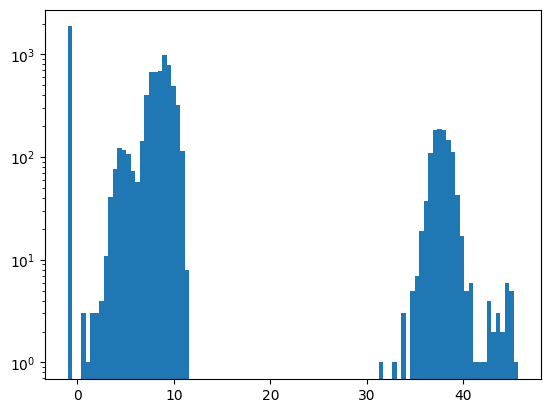

In [ ]:
plt.hist(simdist_unravel[1,:], log=True, bins=100);

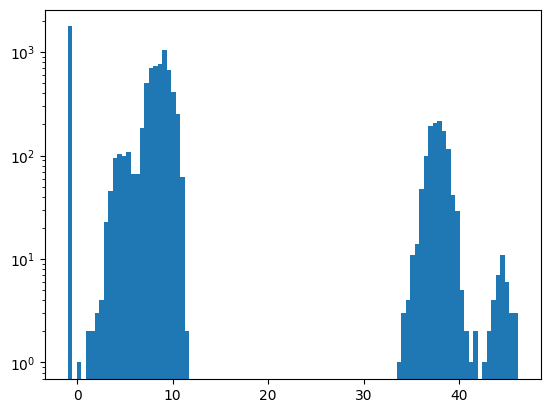

In [ ]:
plt.hist(simdist_unravel[2,:], log=True, bins=100);

In [ ]:
plt.hist(simdist_unravel[3,:], log=True, bins=100);

IndexError: index 3 is out of bounds for dimension 0 with size 3

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

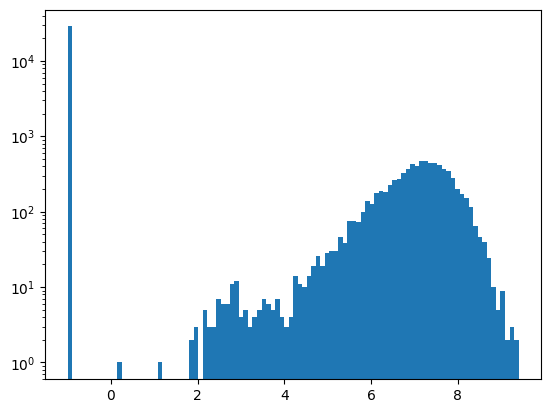

In [ ]:
plt.hist(simdist_unravel[1,:][simdist_unravel[3,:]<1], log=True, bins=100)
plt.hist(simdist_unravel[1,:][simdist_unravel[3,:]>70], log=True, bins=100)

(-2.0, 10.0)

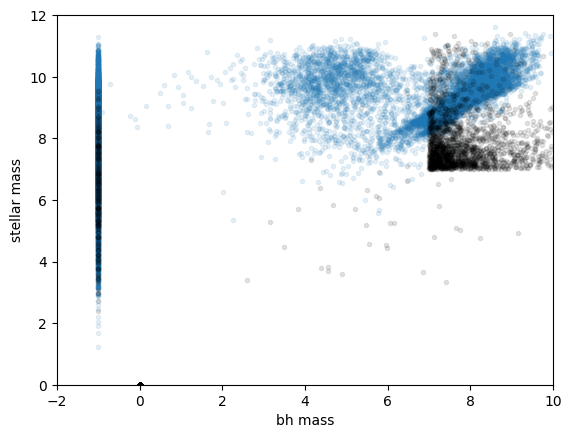

In [ ]:

mask = (simdist_unravel[3,:]!=-1) #& (simdist_unravel[3,:]<50) 
plt.scatter(simdist_unravel[0,:], simdist_unravel[1,:], marker='.', alpha=0.1)
plt.scatter(simdist_unravel[0,:][mask], simdist_unravel[1,:][mask], marker='.', alpha=0.1)

observation_unravel = observation_test.reshape([4, len(observation_test)//npar])
plt.scatter(observation_unravel[0,:], observation_unravel[1,:], marker='.', alpha=0.1, color='k')


plt.ylabel('stellar mass')
plt.xlabel('bh mass')
plt.ylim(0, 12)
plt.xlim(-2, 10)

# Plot the RV relation


In [ ]:
observation.shape

torch.Size([111525, 4])

(0.0, 20.0)

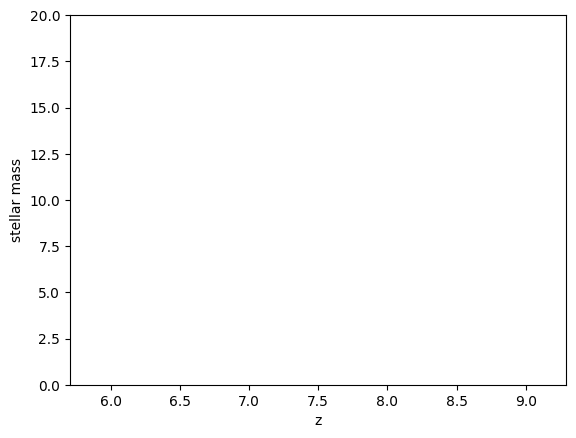

In [ ]:
plt.scatter(simdist_unravel[0,:], simdist_unravel[3,:], marker='.', alpha=0.1)
plt.ylabel('stellar mass')
plt.xlabel('z')
plt.ylim(0, 20)
#plt.xlim(0, 10)

# Plot the RV relation


In [ ]:
simdist_unravel[3,:]

tensor([79.9979, 79.9979, 79.9979,  ...,  0.0000, 79.9979, 79.9979],
       dtype=torch.float64)